### Required Dependencies.

In [ ]:
!pip install matplotlib

#### Run the followings lines to check if installation was successful.

In [1]:
%matplotlib inline

import gym
import sys
import itertools
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from utils import plotting
from collections import defaultdict
from environments.blackjack import BlackjackEnv
from environments.cliff_walking import CliffWalkingEnv

# Monte Carlo and Temporal Difference Learning

---

### Why can't we always rely on Policy / Value Iteration ?

At each state, we look ahead one step at each possible action and next state. 

1.  We can only do this because we have a perfect model of the environment. (the transition matrix $P$). In most applications, this assumption does not hold. We would like an algorithm that can learn from $\mathcal{experience}$, i.e. by simply interacting with the environment
2.  DP methods are polynomial in the number of states. Many real world applications have a very large state space, making DP methods unusable



## Monte-Carlo methods


1.   Monte Carlo (MC) methods can learn directly from experience collected by interacting with the environment. An episode of experience is a series of (State, Action, Reward, Next State) tuples.
2.   MC methods work based on episodes. We sample episodes of experience and make updates to our estimates at the end of each episode. MC methods have high variance (due to lots of random decisions within an episode) but are unbiased.
3. MC Policy Evaluation: Given a policy, we want to estimate the state-value function V(s). Sample episodes of experience and estimate V(s) to be the reward received from that state onwards averaged across all of your experience. The same technique works for the action-value function Q(s, a). Given enough samples, this is proven to converge.



### Environment - Blackjack
* For the MC methods we will use the OpenAI Gym Blackjack-v0 environment. Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over. They’re playing against a fixed dealer.
* Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it’s called ’usable’ at 11. This game is placed with an infinite deck (or with replacement). The game starts with each (player and dealer) having one face up and one face down card.
* The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust).
* After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21. The reward for winning is +1, drawing is 0, and losing is -1.
* The observation of a 3-tuple of: the players current sum, the dealer’s one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1).

## Prediction
Given a policy $\pi$,  can we find the corresponding value function $v_{\pi}$ ? 

Sample episodes of experience and estimate V(s) to be the reward received from that state onwards averaged across all of your experience. The same technique works for the action-value function Q(s, a). Given enough samples, this is proven to converge.

### MC prediction Algorithm
**Input**: <br>
a policy $\pi$ to be evaluated <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$ \quad V(s) \in \mathbb{R}$, arbitrarily, for all $s \in S $ 
$ \quad \textit{VisitCount(s)}$, an empty list, for all $s \in S$

**Loop** (for *num_episodes*): <br>$ \quad $ Generate an episode following $\pi: S_0,A_0,R_1,S_1,A_1,R_2, ..., S_{T-1},A_{T-1},R_T$ <br>$ \quad G \leftarrow 0$ <br>$ \quad $ **Loop** for each step of episode, $t = T-1, T-2, ..., 0$: <br>$ \quad \quad G \leftarrow \gamma G + R_{t+1} $ <br>$ \quad \quad \textit{VisitCount}(S_t) = \textit{VisitCount}(S_t) + 1$ <br>$ \quad \quad V(S_t) = V(S_t) + \frac{1}{\textit{VisitCount}(S_t)} (G_t - V(S_t))$<br>
return $V$

### Implementation
We consider the game of blackjack for this exercice, available [here](https://github.com/dennybritz/reinforcement-learning/blob/master/MC/Blackjack%20Playground.ipynb). I recommend exploring the previous link, to get familiar with the API of the environment. The following code was taken from the same repository (https://github.com/dennybritz/reinforcement-learning/). If you are looking for additional material, I would start there.


#### The BlackJack Environment
This environment actually builds off the gym interface, so you can interact with it using the same function calls. Here's a quick example

In [6]:
# create env
env = BlackjackEnv()

# let's see what's hidden inside this Object
print(vars(env))

# how big is the action space ? 
print ('number of action:',env.action_space.n)

# let's sample a random action
random_action = env.action_space.sample()

# let's simulate one action
observation, reward, done, _ = env.step(random_action)
print('state:',observation)
print('reward:',reward)
print(done)

# observation : the new state after executing action 
# reward      : observed reward after executing action 
# done        : `True` if the episode is over, `False` otherwise

# let's reset the environment (do this when `done` == True)
state = env.reset()

{'action_space': Discrete(2), 'observation_space': Tuple(Discrete(32), Discrete(11), Discrete(2)), 'np_random': RandomState(MT19937) at 0x7F2FD0C87678, 'natural': False, 'dealer': [3, 1], 'player': [7, 10]}
number of action: 2
state: (27, 3, False)
reward: -1
True


Since we want to do policy evaluation, we'll need a policy. Let's create one

In [7]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1   # action 0 (dont take anymore card) or 1 (take one more card)

### EXERCISE 1: complete the following code for MC prediction

In [10]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, max_steps_per_episode=100):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum   = defaultdict(float)   # initialize visit count (how many times passed on one state)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(num_episodes):
        """ IMPLEMENT THIS """
        
        # For debbuging
        #if (i_episode + 1) % 1000 == 0:
            #print("\r Episode {}/{}.".format(i_episode, num_episodes,end="")
        #sys.stdout.flush()

        #generate episode
        #An episode is array of (s, a, r) tuples
        episode = []
        state = env.reset()
        done = False
        
        while not done:                    # create one episode
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            
        # Calculate the targets/returns
        
        # G <- 0
        discounted_return = 0
        
        # loop backwards
        for (state, action, reward) in episode [::-1]:
            #G <- r_{t + 1} + \gamma G
            discounted_return = reward + discount_factor * discounted_return
            
            # VisitCount(s_t) = VisitCount(s_t) + 1
            returns_count[state] = returns_count[state] + 1
            
            # V(s_t) = V(s_t) + (1/VisitCount(s_t))*(G - V(s_t))
            V[state] += 1./returns_count[state] * (discounted_return - V[state])
            
     
    return V

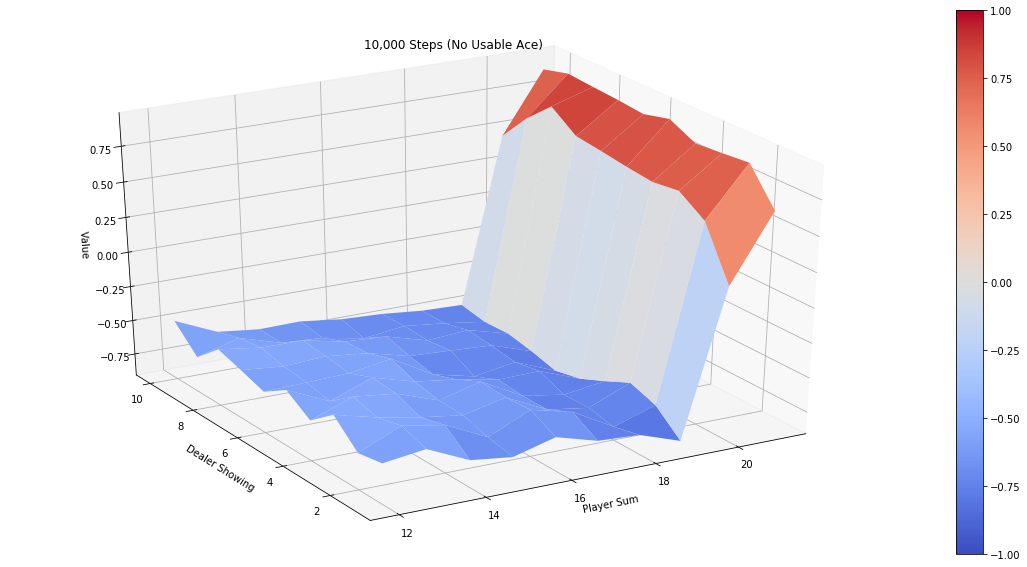

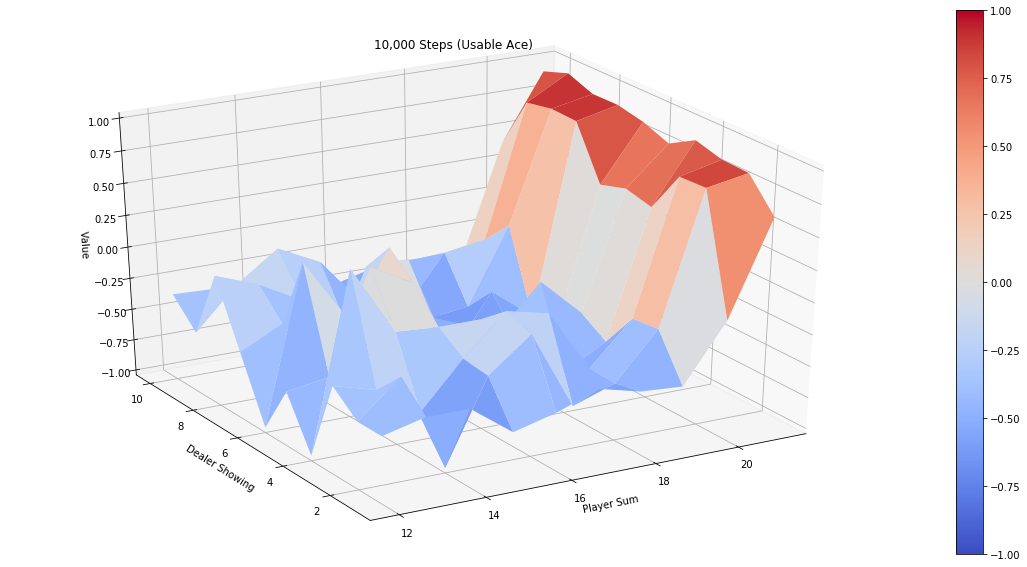

In [11]:
env = BlackjackEnv()
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

##### The expected plots should look like this 
![solution](https://i.imgur.com/Bgfjb5E.png)

Once your algorithm seems to run correctly, run it longer to see what the real value prediction looks like!

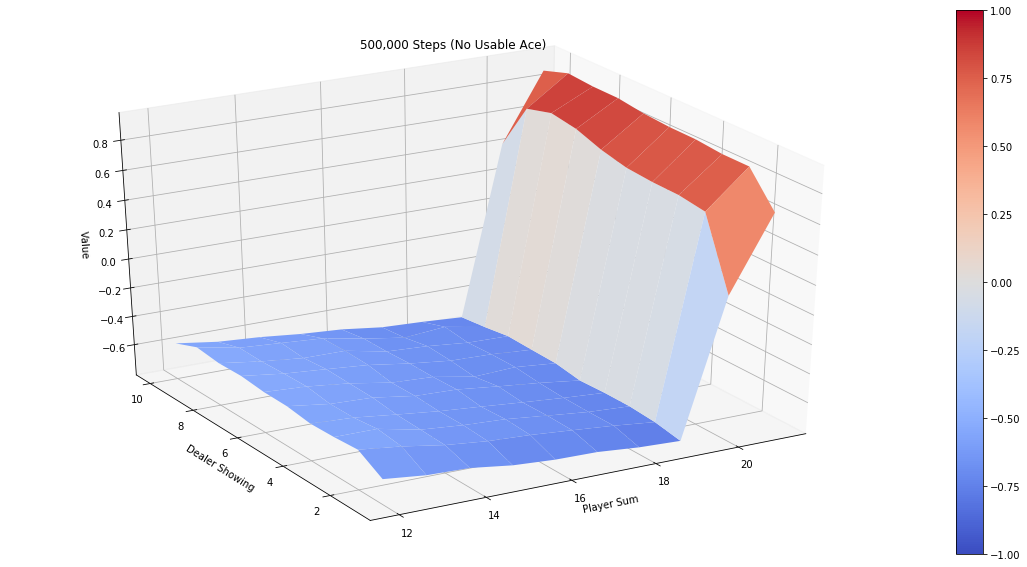

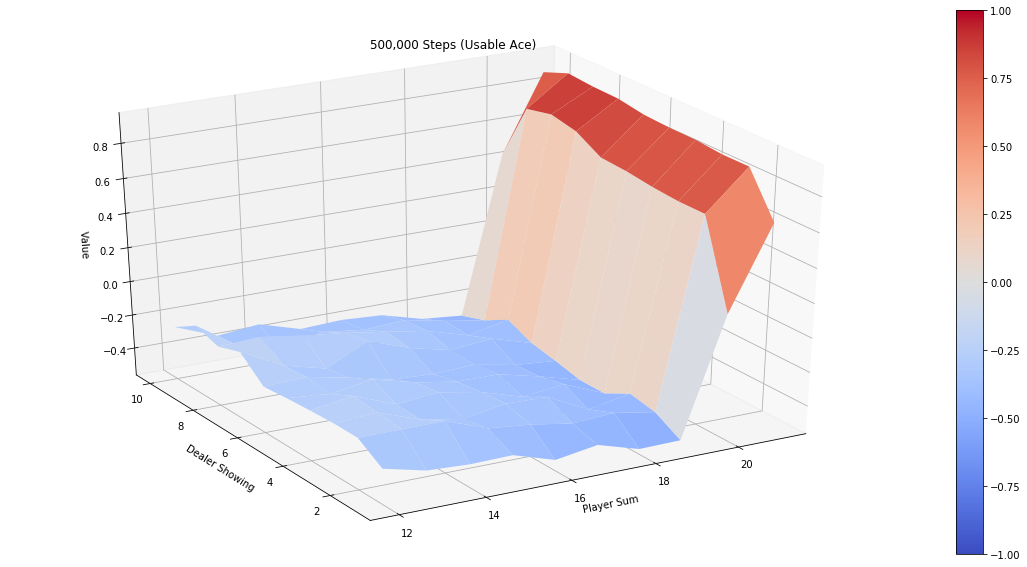

In [12]:
V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

##### The expected plots should look like this 
![solution](https://i.imgur.com/B7efn5Q.png)

As expected, the more episode you run, the better your estimate gets. This is shown by the plots being much smoother for $t=500000$ vs $t=10000$

## Control 
The idea is the same as for Dynamic Programming. Use MC Policy Evaluation to evaluate the current policy then improve the policy greedily. The Problem: How do we ensure that we explore all states if we don't know the full environment?

Solution to exploration problem: Use epsilon-greedy policies instead of full greedy policies. When making a decision act randomly with probability epsilon. This will learn the optimal epsilon-greedy policy.

### MC Control Algorithm
**Input**: <br>
small $\epsilon > 0$  <br>
the number of episodes for which the run the algorithm, *num_episodes*

** Initialize: ** <br>
$ \quad \pi \leftarrow $ an arbitrary $\epsilon$-soft policy <br>
$ \quad Q(s,a) \in \mathbb{R}$ (arbitrarily), for all $s \in S, a \in A(s)$ <br>
$ \quad \textit{VisitCount(s,a)}$, an empty list, for all $s \in S, a \in A(s)$

**Loop** (for *num_episodes*): <br>
$ \quad $ Generate an episode following $\pi: S_0,A_0,R_1,S_1,A_1,R_2, ..., S_{T-1},A_{T-1},R_T$ <br>
$ \quad G \leftarrow 0$ <br>
$ \quad $ **Loop** for each step of episode, $t = T-1, T-2, ..., 0$: <br>
$ \quad \quad \textit{VisitCount}(S_t, A_t) = \textit{VisitCount}(S_t, A_t) + 1$ <br>
$ \quad \quad G \leftarrow \gamma G + R_{t+1} $ <br>
$ \quad \quad Q(S_t, A_t) = Q(S_t, A_t) + \frac{1}{\textit{VisitCount}(S_t, A_t)} (G_t - Q(S_t, A_t))$

$\quad $** Update ** $\pi$ to be $\epsilon$-greedy w.r.t. the update $Q$ values

return $Q, \ \pi$

### Important note: 
Since we are doing control, we will want to estimate the value of (state, action) pairs. We will therefore be working with $Q's$ and not $V's$

### Implementation
It's important to break ties arbitrarily when doing control. This is especially important when you initialize all $Q$ or $V$ array to all 0s. If you don't break ties arbitrarily, you will end up always choosing the same action!. Here is a ** argmax ** function that break ties randomly

In [15]:
def argmax(numpy_array):
    """ argmax implementation that chooses randomly between ties """
    max_indices = np.where(numpy_array == numpy_array.max())[0]
    return max_indices[np.random.randint(max_indices.shape[0])]

We are also providing you with the following function: Given a $Q$ dictionnary and $\epsilon$, it returns a $\epsilon$-greedy policy. Also, since the argument $Q$ is a python object, the returned $\epsilon$-greedy policy will automatically update as you change the $Q$ values.

In [16]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

### EXERCISE 2: complete the following code for MC control

In [ ]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1, max_steps_per_episode=100):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum   = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n) 
    
    for i_episode in range(num_episodes):
        """ IMPLEMENT HERE """

        for t in range(max_steps_per_episode):
            """ IMPLEMENT HERE """
            
    return Q, policy

In [ ]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

In [ ]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

##### The expected plots should look like this 
![solution](https://i.imgur.com/eQkuPYx.png)

### Comments on the BlackJack Env

Although we have complete knowledge of the environment in the blackjack task, it would not be easy to apply DP methods to compute the value function. DP methods require the distribution of next events—in particular, they require the environments dynamics as given by the four-argument function p—and it is not easy to determine this for blackjack. For example, suppose the player’s sum is 14 and he chooses to stick. What is his probability of terminating with a reward of +1 as a function of the dealer’s showing card? All of the probabilities must be computed before DP can be applied, and such computations are often complex and error-prone. In contrast, generating the sample games required by Monte Carlo methods is easy. This is the case surprisingly often; the ability of Monte Carlo methods to work with sample episodes alone can be a significant advantage even when one has complete knowledge of the environment’s dynamics

### Comments on MC methods
So far we have been using the following update rule for MC Control and Prediction

1) For a given state action pair $(s_t, a_t)$, observe the return $G_t$

2) Update your estimate in this fashion $V(s_t)$ = $V(s_t) + \frac{1}{VisitCount(s_t)} \bigg[G_t - V(s_t)\bigg] $

It's important to notice that this assings **equal importance to all returns**. In general, this can be problematic when working with nonstationary environments. In this setup, it would be better to *trust/rely more* on newer $Returns$, and rely less on older ones. One easy way to achieve this is by using the following update rule

$$V(s_t) \leftarrow V(s_t) + \alpha \bigg[ G_t - V(s_t) \bigg]$$

This update rule will assign exponentially decresing weights over time. Feel free to (re) implement the above exercises with this update rule. You will not need the returns_count array anymore 

### Drawbacks of Monte Carlo methods


1.   You need to wait until the end of the episode to perform an update. This can be probablematic if the episode lengths are very long, (or even infinite!)
2.   MC methods, while unbiased, tend to have high variance. To see this, note that $$G_t = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T - t - 1}R_{T}$$ What will be the variance of $G_t$ ? Assuming all the returns are independent*, $$Var(G_t) = Var(R_{t+1}) + \gamma^2 Var(R_{t+2}) + ... + \gamma^{2(T - t - 1)}Var(R_{T})$$

which can become quite large for long episodes.

Ideally, we would like a way to trade off bias for variance. This leads us to the next topic of Temporal Difference Learning. 

---


*Independence of returns is not true in general, but the intuition of the variance growing with the size of the episode is still valid


## Temporal Difference (TD) learning
TD-Learning is a combination of Monte Carlo and Dynamic Programming ideas. Like Monte Carlo, TD works based on samples and doesn't require a model of the environment. Like Dynamic Programming, TD uses bootstrapping to make updates. At the core of TD learning is the following update rule 
$$V(s_t) \leftarrow V(s_t) + \alpha \bigg[ R_{t+1} + \gamma V(S_{t+1}) - V(s_t) \bigg]$$

(to contrast with MC, which updates like so )
$$V(s_t) \leftarrow V(s_t) + \alpha \bigg[ G_t - V(s_t) \bigg]$$

In other words, for every update, the target is actually based on our predicted value for the next state, $ R_{t+1} + \gamma V(S_{t+1})$, instead of being the sum of observed rewards, $G_t$


Why is this valid ? simply because
\begin{align*}
  v_{\pi}(s) &= \mathbb{E}[G_t | S_t = s] \\
                    &= \mathbb{E}[R_{t+1} + \gamma G_{t+1} | S_t = s] \\
                    &= \mathbb{E}[R_{t+1} + \gamma v_{\pi}(S_{t+1}) | S_t = s]
\end{align*}



Here is the pseudo code for doing policy evaluation with TD. We will not implement it in this tutorial, but feel free to go back on the previous exercice and modify them from MC to TD.

### TD  prediction Algorithm
**Input**: <br>
a policy $\pi$ to be evaluated <br>
step size $\alpha \in (0, 1]$ <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$ \quad V(s) \in \mathbb{R}$, arbitrarily, for all $s \in S $, except that $V(terminal)=0$ <br>

**Loop** (for *num_episodes*): <br>
$ \quad $ Initialize $S$ <br>
$ \quad $ **Loop** for each step of the episode: <br>
$ \quad \quad A \leftarrow $ action given by $\pi$ for S <br>
$ \quad \quad $ Take action $A$, observe $R, S'$ <br>
$ \quad \quad V(S) \leftarrow V(S) + \alpha \big[ R + \gamma V(S') - V(s) \big]$ <br>
return $V$

### TD Control and Q-Learning
Let's skip prediction for TD methods and go straight to control. Arguably the most famous TD algorithm is Q-Learning, with the following pseudocode. 

### Q-learning Algorithm
**Input**: <br>
step size $\alpha \in (0, 1]$ <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$\quad Q(s, a) \in \mathbb{R}$ arbitrarily, for all $s \in S, a \in A(s)$, except that $Q(terminal, \cdot)=0$ <br>

**Loop** (for *num_episodes*): <br>
$ \quad $ Initialize $S$ <br>
$ \quad $ **Loop** for each step of the episode: <br>
$ \quad \quad $ Choose $A$ from $S$ using policy derived from $Q$, (e.g. $\epsilon$-greedy) <br>
$ \quad \quad $ Take action $A$, observe $R, S'$ <br>
$ \quad \quad Q(S, A) \leftarrow Q(S, A) + \alpha \big[ R + \gamma \max_a Q(S', a) - Q(s,a) \big]$ <br>
$ \quad $ until S is terminal 

return $Q, \ \pi$

### Implementation
We consider the CliffWorld for this exercice, available [here](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py). The API is the same as the other environment, i.e. you can use the same function calls to interact with it. 
![env](https://i.imgur.com/qz5Kdyf.png)

### EXERCISE 3: complete the following code for Q-Learning

In [23]:
def q_learning(env, num_episodes, discount_factor=1.0, epsilon=0.05, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))  
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode +1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # reset environment at the beginning of every episode
        state = env.reset()
        
        for t in itertools.count():
            
            """ IMPLEMENT HERE """
            
            #Select an action from the stochastic policy
            probs = policy(state) # probability of states of action (array of size of action)
            action = np.random.choice(np.arange(len(probs)), p = probs)
            
            # Execute the action in the environnement
            next_state, reward, done, _ = env.step(action)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD update 
            greedy_next_action = argmax(Q[next_state])
            
            # TD target = r + \gamma max_a Q(s', a)
            td_target = reward + discount_factor * Q[next_state][greedy_next_action]
            
            # Update the Q-values
            Q[state][action] += alpha * (td_target - Q[state][action])
            
            # if episode ended, exit the loop
            if done:
                break
                
            # update the state
            state = next_state
            
               
    return Q, stats

Episode 499/500.

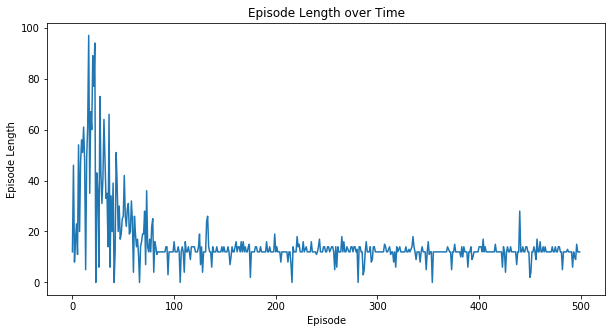

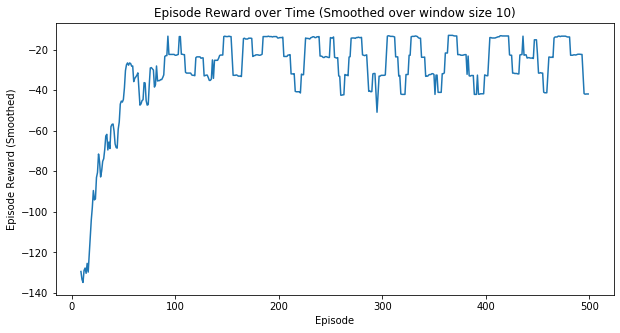

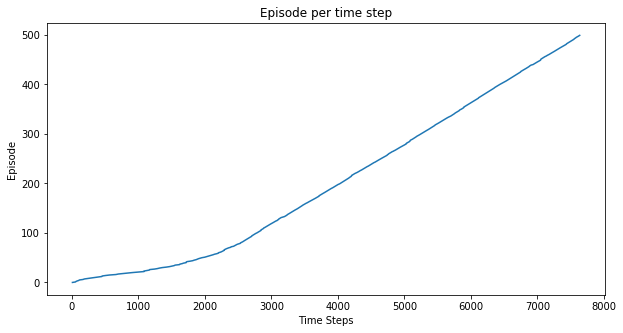

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [18]:
env = CliffWalkingEnv()
Q, stats_q_learning = q_learning(env, num_episodes=500)
plotting.plot_episode_stats(stats_q_learning)

In [26]:
policy

NameError: name 'policy' is not defined

In [19]:
def plot_values(Q, state_shape=((4, 12))):
    """ helper method to plot a heat map of the states """
    
    values = np.zeros((4 * 12))
    max_a  = [0 for _ in range(values.shape[0])]
    for key, value in Q.items():
        values[key] = max(value)
        max_a[key] = int(argmax(value))
        
    def optimal_move(i, j):
        left, right, down, up  = (i, max(j-1, 0)), (i, min(11, j+1)), (min(3, i+1), j), (max(0, i-1), j)
        arr = np.array([values[up], values[right], values[down], values[left]])
        if i == 2   and j != 11: arr[2] = -9999
        if i == 0:  arr[0] = -999
        if j == 0:  arr[3] = -999
        if j == 11: arr[1] = -999
        return argmax(arr)
    
    # reshape the state-value function
    values = np.reshape(values, state_shape)
    # plot the state-value function
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.imshow(values)
    arrows = ['^', '>', 'v', '<']
    index = 0
    for (j, i), label in np.ndenumerate(values):
        ax.text(i, j, np.round(label, 3), ha='center', va='center', fontsize=12)
        if j != 3 or i==0:
            ax.text(i, j + 0.4 , arrows[optimal_move(j, i)], ha='center', va='center', fontsize=12, color='red')
        index += 1
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.title('State-Value Function')
    plt.show()

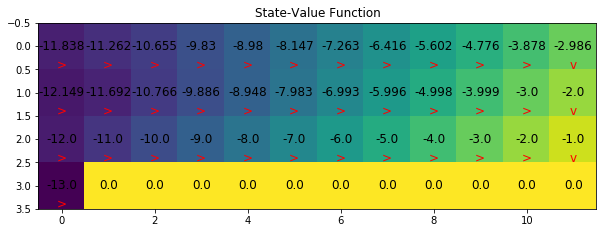

In [20]:
plot_values(Q)

from the heatmap, try to follow a greedy policy. Does the trajectory align with optimal path in the previous picture ?

### SARSA
Q-learning is an offline method, since the target update does not depend on the behavior policy (because of the max operator). The online version of Q-Learning is known as SARSA (which stands for State, Action, Reward, State, Action). Notice that in the following pseudocode, the action selected in the target update is the same as the action used in the next timestep

### SARSA Algorithm
**Input**: <br>
step size $\alpha \in (0, 1]$ <br>
the number of episodes for which the run the algorithm, *num_episodes*

**Initialize**:

$\quad Q(s, a) \in \mathbb{R}$ arbitrarily, for all $s \in S, a \in A(s)$, except that $Q(terminal, \cdot)=0$ <br>

**Loop** (for *num_episodes*): <br>
$ \quad $ Initialize $S$ <br>
$ \quad $ Choose $A$ from $S$ using policy derived from $Q$, (e.g. $\epsilon$-greedy) <br>
$ \quad $ **Loop** for each step of the episode: <br>
$ \quad \quad $ Take action $A$, observe $R, S'$ <br>
$ \quad \quad $ Choose $A'$ from $S'$ using policy derived from $Q$, (e.g. $\epsilon$-greedy) <br>
$ \quad \quad Q(S, A) \leftarrow Q(S, A) + \alpha \big[ R + \gamma Q(S', A') - Q(s,a) \big]$ <br>
$ \quad $ until S is terminal 

return $Q, \ \pi$

### EXERCISE 4: complete the following code for SARSA

In [27]:
def SARSA(env, num_episodes, discount_factor=1.0, epsilon=0.1, alpha=0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))  
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode +1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        """ IMPLEMENT HERE """
        # reset environment at the beginning of every episode
        state = env.reset()
        
        #Select an action from the stochastic policy
        probs = policy(state) # probability of states of action (array of size of action)
        action = np.random.choice(np.arange(len(probs)), p = probs)
        
        for t in itertools.count():
            
            """ IMPLEMENT HERE """
            
            
            # Execute the action in the environnement
            next_state, reward, done, _ = env.step(action)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            #Select an action from the stochastic policy
            probs = policy(next_state) # probability of states of action (array of size of action)
            next_action = np.random.choice(np.arange(len(probs)), p = probs)
            
            # TD update 
            #greedy_next_action = argmax(Q[next_state])
            
            # TD target = r + \gamma max_a Q(s', a)
            sarsa_target = reward + discount_factor * Q[next_state][next_action]
            
            # Update the Q-values
            Q[state][action] += alpha * (sarsa_target - Q[state][action])
            
            # if episode ended, exit the loop
            if done:
                break
                
            # update the state
            state = next_state
            

    return Q, stats

In [21]:
import numpy as np
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
Q, stats_q_learning = SARSA(env, num_episodes=500)
plotting.plot_episode_stats(stats_q_learning)

KeyboardInterrupt: 

As seen in the slides, you should expect the performance of SARSA to be better than Q-Learning during training

In [ ]:
plot_values(Q)

### Exercice 5 : 
how will SARSA and Q-learning compare if you evaluate the learned policies with $\epsilon$=0 ?
